In [37]:
import random
import numpy as np
import matplotlib.pyplot as plt
from math import dist

In [38]:
MAP_SCALE = 300 #mierka mapy 
DRONE_RADIUS = MAP_SCALE/20
FOR_ORIGINAL = 5
STARTING_DRONES = 1
μ = 20

In [39]:
def add_customers(customers):
    for _ in range(50):
        random_x = random.randrange(MAP_SCALE)
        random_y = random.randrange(MAP_SCALE)
        customers.append((random_x,random_y))
    return customers

def add_drone(drones):
    random_x = random.randrange(MAP_SCALE)
    random_y = random.randrange(MAP_SCALE)
    drones.append((random_x,random_y))
    return drones

In [40]:
def change_positions_of_customers(customers):# krok = [0 : MAP_SCALE/5]
    new_customers = []                       # smer = [0 : 2pi]
    for customer in customers:                
        random_step = random.randrange(MAP_SCALE/5)
        random_angle = random.random()* 2 * np.pi
        new_x = int(np.round(customer[0] + random_step * np.cos(random_angle)))
        new_y = int(np.round(customer[1] + random_step * np.sin(random_angle)))
        if new_x < MAP_SCALE and new_y < MAP_SCALE and new_x >= 0 and new_y >= 0:
            new_customers.append((new_x,new_y))
    return new_customers

In [41]:
def create_mask(drones):
    mask = np.zeros((MAP_SCALE,MAP_SCALE),dtype=int)
    for x in range(MAP_SCALE):
        for y in range(MAP_SCALE):
            for drone in drones:
                if dist(drone,(x,y)) <= DRONE_RADIUS:
                    if mask[x,y] == 0:
                        mask[x,y] += 1
    return mask

In [42]:
def find_Φ(drones,customers):
    matched = 0
    together = len(customers)
    for customer in customers:
        for drone in drones:
            if dist(drone,customer) <= DRONE_RADIUS: 
                matched += 1
                break

    Φ = matched / together
    
    return Φ

In [43]:
def get_scale(lenght):
    if lenght % 2:
        return 1
    else:
        return 6


In [44]:
def mutation(drones):
    new_drones = []
    mutation_size = int((len(drones)*(1-GENETIC_STABILITY)))
    drone_subarray = random.sample(drones, k = mutation_size)
    for drone in drones:
        if drone in drone_subarray:
            random_step = random.randrange(int(MAP_SCALE/get_scale(len(drones))))
            random_angle = random.random()* 2 * np.pi
            new_x = int(np.round(drone[0] + random_step * np.cos(random_angle)))
            new_y = int(np.round(drone[1] + random_step * np.sin(random_angle)))
            if new_x < MAP_SCALE and new_y < MAP_SCALE and new_x >= 0 and new_y >= 0:
                new_drones.append((new_x,new_y))
            else:
                new_drones.append(drone)
        else:
            new_drones.append(drone)
    return new_drones

def crossing(drones1,drones2):
    new_drones = []
    mutation_size = int((len(drones1)*(1-GENETIC_STABILITY)))
    drone_subarray = random.sample(drones1, k = mutation_size)
    for drone1 in drones1:
        if drone1 in drone_subarray:
            x1,y1 = drone1
            x2,y2 = random.choice(drones2)
            if x1 == x2 or y1 == y2:
                new_drones.append(drone1)
            else:
                new_x = random.randrange(min(x1,x2),max(x1,x2))
                new_y = random.randrange(min(y1,y2),max(y1,y2))
                new_drones.append((new_x,new_y))
        else:
            new_drones.append(drone1)
    return new_drones

In [45]:
def evaluate_population(population,customers):
    evaluated_population = []
    for candidate in population:
        evaluated_population.append((candidate,find_Φ(candidate,customers)))
    return evaluated_population

In [46]:
def initialize_population(μ):
    population = []
    for _ in range(μ):
        drones = [] 
        for _ in range(STARTING_DRONES):
            drones = add_drone(drones)
        population.append(drones)
    return population

In [47]:
def find_best(population):
    return np.max(np.array(population)[:,1])

def best_drones(population,best):
    for candidate,Φ in population:
        if Φ == best:
            return candidate

In [48]:
def mapping_fit(population):    # identita
    fitness = np.array(population)[:,1]
    mapped_Φ = fitness 
    return mapped_Φ #TU SA NIC NEMENI 
    
def selection_probability(mapped_Φ):   # proporcionalna selekcia
    return mapped_Φ / sum(mapped_Φ)

def select_parent(ps, population):       # SSwR vzorkovanie - nepresne (maximalne rozpatie)
    choosen = random.random()

    index = 0
    sum_η = ps[index] 
    while(sum_η < choosen):
        index += 1
        sum_η += ps[index] 

    return population[index]


def selection(population):
    mapped_Φ = mapping_fit(population)
    parent_place = mapped_Φ*μ / sum(mapped_Φ) 
    parents = []
    μ_counter = 0
    for index in range(len(parent_place)):
        while parent_place[index] >= 1:
            parents.append(population[index])
            parent_place[index] -= 1
            μ_counter += 1 
    if sum(parent_place) > 0:
        ps = parent_place / sum(parent_place)
        while μ_counter < μ:
            parents.append(select_parent(ps, population))
            μ_counter += 1
        
    return parents

In [49]:
def selection_series(customers,start_population):
    population = start_population
    for _ in range(SELECTION_TO_ADD_DRONE):
        new_population = []
        final_population = []
        parents = selection(population)
        for parent in parents:
            if random.random() > 0.1:
                new_population.append(mutation(parent[0]))
            else:
                new_population.append(crossing(parent[0],random.choice(parents)[0]))
        new_population = evaluate_population(new_population,customers)
        
        top_for_original = np.sort(np.array(population)[:,1])[-FOR_ORIGINAL:]
        
        for original_candidate,original_candidate_Φ in population:
            if original_candidate_Φ in top_for_original:
                final_population.append((original_candidate,original_candidate_Φ))
        
        top_for_new = np.sort(np.array(new_population)[:,1])[-(μ-FOR_ORIGINAL):]
        for new_candidate,new_candidate_Φ in new_population:
            if new_candidate_Φ in top_for_new:
                final_population.append((new_candidate,new_candidate_Φ))

        population = final_population
    return population

In [50]:
def create_map(customers):
    map_copy = np.zeros((MAP_SCALE,MAP_SCALE),dtype=int)
    for customer in customers:
        map_copy[customer] += 1
    return map_copy

C:\Users\Tomas\AppData\Local\Temp/ipykernel_6368/4187791937.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.max(np.array(population)[:,1])
C:\Users\Tomas\AppData\Local\Temp/ipykernel_6368/1568931566.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  top_for_original = np.sort(np.array(population)[:,1])[-FOR_ORIGINAL:]
C:\Users\Tomas\AppData\Local\Temp/ipykernel_6368/1568931566.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengt

At the time 8.0 was active 31 drones
To cover 50 people and average people for drone was 1.61
At the time 9.0 was active 48 drones
To cover 85 people and average people for drone was 1.77
At the time 10.0 was active 58 drones
To cover 109 people and average people for drone was 1.88


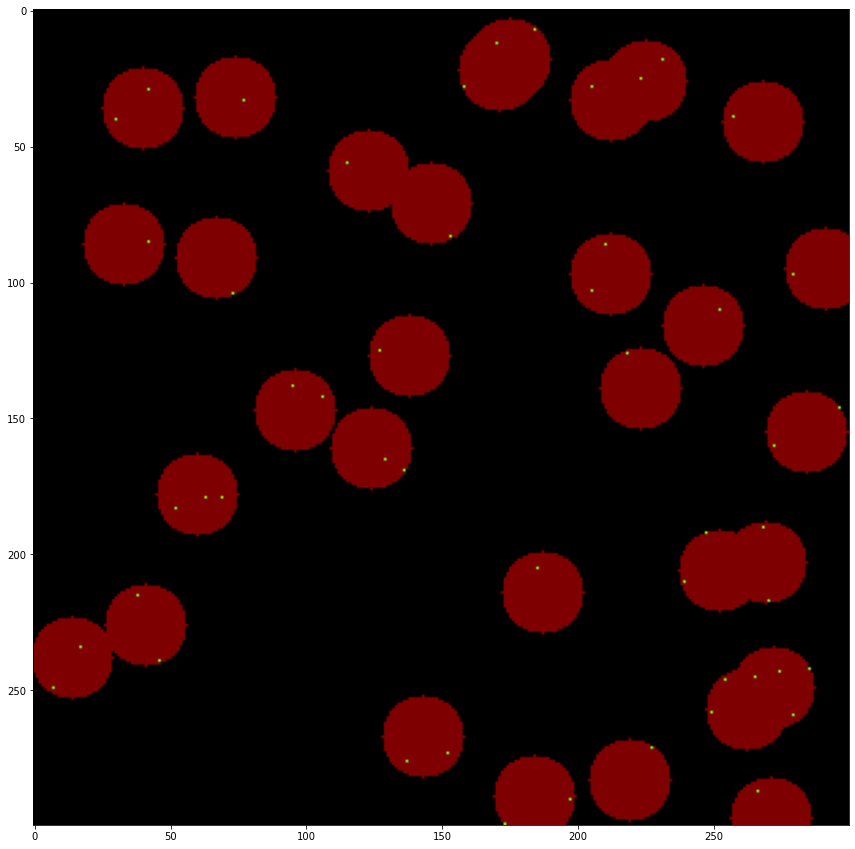

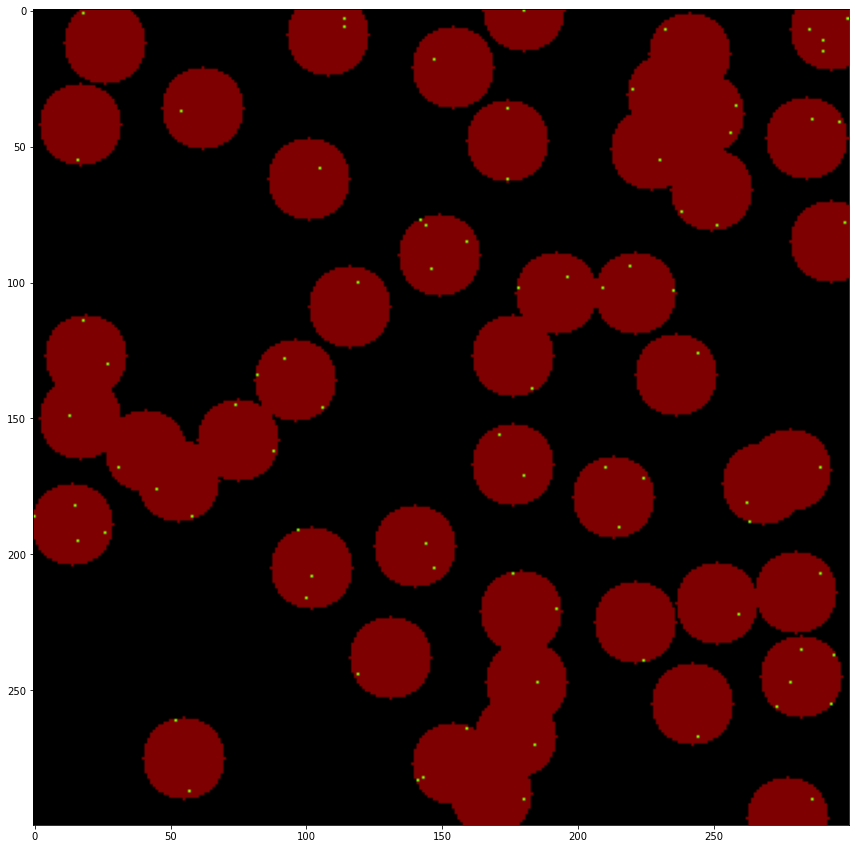

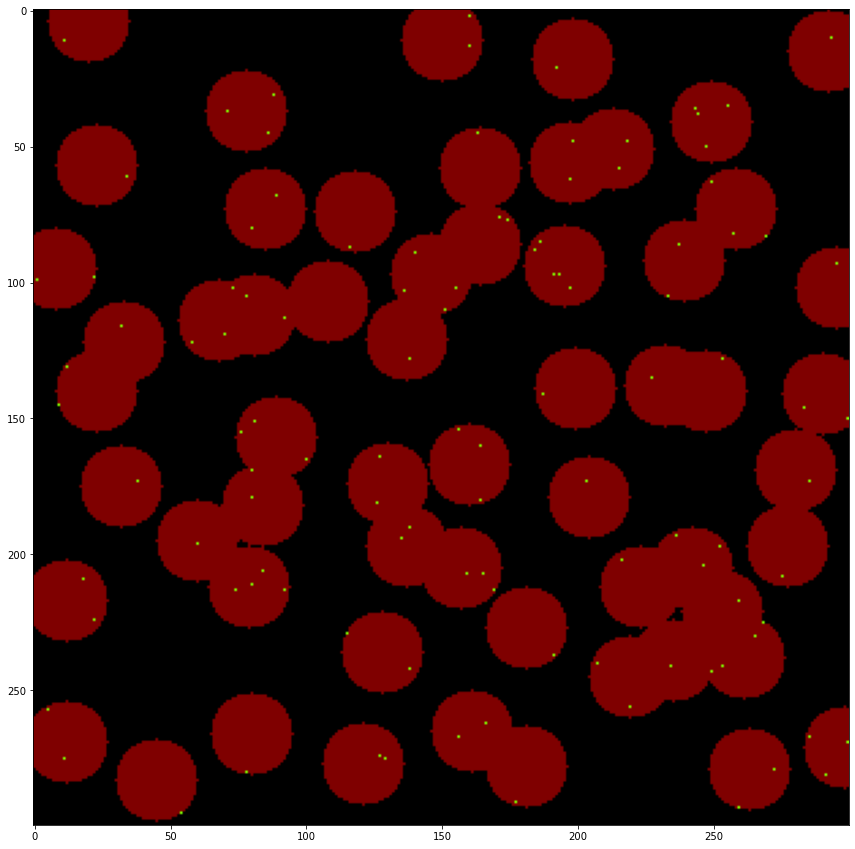

In [51]:
customers = []
GENETIC_STABILITY = 0.3
SELECTION_TO_ADD_DRONE = 25

for interval in range(5):
    if not interval % 2:
        if interval < 11:
            customers = add_customers(customers)
        population = initialize_population(μ)
        population = evaluate_population(population,customers)
        best = find_best(population)
        best_changes = True
        last_best = 0
        while best < 1:
            if best == last_best:
                for drones,Φ in population:
                    drones = add_drone(drones)
            population = selection_series(customers,population)
            last_best = best
            best = find_best(population)
            GENETIC_STABILITY = best
            SELECTION_TO_ADD_DRONE = 100
        print("At the time {0} was active {1} drones".format(8+interval/2,len(best_drones(population,best))))
        print("To cover {0} people and average people for drone was {1:.2f}".format(len(customers),len(customers)/len(best_drones(population,best))))
        actual_map = create_map(customers)
        mask = create_mask(best_drones(population,best))
        image = np.zeros((MAP_SCALE,MAP_SCALE,3),dtype=int)
        image[:,:,0] += mask*127
        image[:,:,1] += actual_map*255 
        
        plt.figure(figsize = (15,15))
        plt.imshow(image)
        
        customers = change_positions_of_customers(customers)   
    customers = change_positions_of_customers(customers)

       